In [ ]:
!pip install yfinance backtrader tensorflow scikit-learn matplotlib IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.0 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
%matplotlib inline

In [ ]:
symbol = 'AAPL'
data_df = yf.download(symbol, period='2y', interval='1d')
data_df.dropna(inplace=True)
data_df.reset_index(inplace=True)

if isinstance(data_df.columns, pd.MultiIndex):
    data_df.columns = data_df.columns.get_level_values(1)
data_df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


data_df['Return'] = data_df['Close'].pct_change()


def compute_atr(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

data_df['ATR'] = compute_atr(data_df, period=14)


data_df['SMA14'] = data_df['Close'].rolling(window=14).mean()
data_df['IRS'] = (data_df['Close'] - data_df['SMA14']) / data_df['SMA14']


data_df.dropna(inplace=True)

return_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_return = return_scaler.fit_transform(data_df['Return'].values.reshape(-1, 1))

atr_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_atr = atr_scaler.fit_transform(data_df['ATR'].values.reshape(-1, 1))

irs_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_irs = irs_scaler.fit_transform(data_df['IRS'].values.reshape(-1, 1))


scaled_features = np.hstack((scaled_return, scaled_atr, scaled_irs))
num_features = scaled_features.shape[1]  # should be 3

def create_dataset_for_next_return(features_array, lookback):
    """
    Generates X (with shape: (n_samples, lookback, num_features)) and
    y (next-period scaled return, taken from the first column).
    """
    X, y = [], []
    for i in range(lookback, len(features_array) - 1):
        X.append(features_array[i - lookback:i, :])
        y.append(features_array[i + 1, 0])
    return np.array(X), np.array(y)

lookback = 10
X, y = create_dataset_for_next_return(scaled_features, lookback)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
X_lstm_cnn = X
X_mlp = X.reshape((X.shape[0], lookback* num_features))


split = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X_lstm_cnn[:split], X_lstm_cnn[split:]
X_train_cnn, X_test_cnn  = X_lstm_cnn[:split], X_lstm_cnn[split:]
X_train_mlp, X_test_mlp = X_mlp[:split],     X_mlp[split:]
y_train, y_test = y[:split],         y[split:]

from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from tensorflow.keras import Sequential

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def build_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model((lookback, num_features))
cnn_model  = build_cnn_model((lookback, num_features))
mlp_model  = build_mlp_model(lookback * num_features)

print("Training LSTM model...")
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, verbose=0)

print("Training CNN model...")
cnn_model.fit(X_train_cnn, y_train, epochs=100, batch_size=16, verbose=0)

print("Training MLP model...")
mlp_model.fit(X_train_mlp, y_train, epochs=100, batch_size=16, verbose=0)

class EnsemblePredictorReturn:
    def __init__(self, scaler, lookback, lstm_model, cnn_model, mlp_model,num_features):
        self.scaler = scaler
        self.lookback = lookback
        self.lstm_model = lstm_model
        self.cnn_model = cnn_model
        self.mlp_model = mlp_model
        self.num_features = num_features

    def preprocess(self, data_window):

        x_lstm = np.array(data_window).reshape(1, self.lookback, self.num_features)
        x_cnn  = np.array(data_window).reshape(1, self.lookback, self.num_features)
        x_mlp  = np.array(data_window).reshape(1, self.lookback * self.num_features)
        return x_lstm, x_cnn, x_mlp

    def predict(self, scaled_window):

        x_lstm, x_cnn, x_mlp = self.preprocess(scaled_window)
        pred_lstm = self.lstm_model.predict(x_lstm, verbose=0)
        pred_cnn  = self.cnn_model.predict(x_cnn,  verbose=0)
        pred_mlp  = self.mlp_model.predict(x_mlp,  verbose=0)
        ensemble_scaled = (pred_lstm + pred_cnn + pred_mlp) / 3.0
        unscaled_return = self.scaler.inverse_transform(ensemble_scaled)
        return float(unscaled_return[0][0])



ensemble_pred = EnsemblePredictorReturn(
    scaler     = return_scaler,
    lookback   = lookback,
    lstm_model = lstm_model,
    cnn_model  = cnn_model,
    mlp_model  = mlp_model
    ,num_features=num_features
)


pred_lstm_scaled = lstm_model.predict(X_test_lstm)
pred_cnn_scaled  = cnn_model.predict(X_test_cnn)
pred_mlp_scaled  = mlp_model.predict(X_test_mlp)
pred_ensemble_scaled = (pred_lstm_scaled + pred_cnn_scaled + pred_mlp_scaled) / 3.0
pred_ensemble_unscaled = return_scaler.inverse_transform(pred_ensemble_scaled)
y_test_unscaled = return_scaler.inverse_transform(y_test.reshape(-1,1))


y_test_unscaled = y_test_unscaled.ravel()
pred_ensemble_unscaled = pred_ensemble_unscaled.ravel()

#mse = mean_squared_error(y_test_unscaled, pred_ensemble_unscaled)
#mae = mean_absolute_error(y_test_unscaled, pred_ensemble_unscaled)
#print(f"Ensemble MSE on test: {mse:.6f}")
#print(f"Ensemble MAE on test: {mae:.6f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training LSTM model...
Training CNN model...
Training MLP model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


In [ ]:
import backtrader as bt
import matplotlib.pyplot as plt
class ReturnPredictionStrategy(bt.Strategy):
    params = (
        ('lookback', 10),
        ('threshold_up', 0.0),
        ('threshold_down', 0.0),
        ('fraction', 0.2),
    )

    def __init__(self):

        self.data_close = self.datas[0].close
        self.closes = []
        self.order = None

        self.atr = bt.indicators.ATR(self.data, period=14)
        self.sma14 = bt.indicators.SimpleMovingAverage(self.data.close, period=14)

    def next(self):
        # Prediction
        self.closes.append(self.data_close[0])
        if len(self.closes) < self.p.lookback + 1:
            return
        raw_close_window = np.array(self.closes[-(self.p.lookback + 1):])
        returns_window = (raw_close_window[1:] - raw_close_window[:-1]) / raw_close_window[:-1]


        atr_window = [self.atr[-i] for i in range(self.p.lookback - 1, -1, -1)]
        atr_window = np.array(atr_window)
        close_window = [self.data_close[-(self.p.lookback - i)] for i in range(1, self.p.lookback + 1)]
        sma_window = [self.sma14[-(self.p.lookback - i)] for i in range(1, self.p.lookback + 1)]

        irs_window = [(c - s) / s if s != 0 else 0 for c, s in zip(close_window, sma_window)]
        irs_window = np.array(irs_window)

        scaled_return_window = return_scaler.transform(returns_window.reshape(-1, 1))
        scaled_atr_window    = atr_scaler.transform(atr_window.reshape(-1, 1))
        scaled_irs_window    = irs_scaler.transform(irs_window.reshape(-1, 1))

        scaled_window = np.hstack([scaled_return_window, scaled_atr_window, scaled_irs_window])
        predicted_return = ensemble_pred.predict(scaled_window)


        if self.order:
            self.cancel(self.order)
        # trading logic
        current_pos_size = self.position.size
        print(f"Predicted Return: {predicted_return:.4f}")

        if predicted_return > self.p.threshold_up:
            if current_pos_size <= 0:
                if current_pos_size < 0:
                    self.order = self.close()
                    self.log(f"CLOSE SHORT => predicted_return={predicted_return:.4f}")
                size = int(self.broker.get_cash() * self.p.fraction // self.data_close[0])
                if size > 0:
                    self.order = self.buy(size=size)
                    self.log(f"BUY {size} shares => predicted_return={predicted_return:.4f}")

        elif predicted_return < self.p.threshold_down:
            if current_pos_size >= 0:
                if current_pos_size > 0:
                    self.order = self.close()
                    self.log(f"CLOSE LONG => predicted_return={predicted_return:.4f}")
                size = int(self.broker.get_cash() * self.p.fraction // self.data_close[0])
                if size > 0:
                    self.order = self.sell(size=size)
                    self.log(f"SELL {size} shares (short) => predicted_return={predicted_return:.4f}")
        else:
            if current_pos_size != 0:
                self.order = self.close()
                self.log(f"CLOSE => predicted_return={predicted_return:.4f}")

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Rejected]:
            if order.status == order.Completed:
                if order.isbuy():
                    self.log(f"BUY EXECUTED @ {order.executed.price:.2f}")
                else:
                    self.log(f"SELL EXECUTED @ {order.executed.price:.2f}")
            self.order = None

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f"{dt.isoformat()} | {txt}")

cerebro = bt.Cerebro()
cerebro.addstrategy(ReturnPredictionStrategy, lookback=lookback)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days, riskfreerate=0.0)

data_df_bt = data_df.copy()
if 'Date' in data_df_bt.columns:
    data_df_bt.set_index('Date', inplace=True)
data_bt = bt.feeds.PandasData(dataname=data_df_bt)
cerebro.adddata(data_bt)

cerebro.broker.setcash(100000.0)
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
results = cerebro.run()
strategy = results[0]

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())
sharpe = strategy.analyzers.sharpe.get_analysis()
trade_analysis = strategy.analyzers.trade_analyzer.get_analysis()

if 'total' in trade_analysis and 'closed' in trade_analysis['total']:
    total_closed = trade_analysis['total']['closed']
    total_won = trade_analysis['won']['total']
    win_rate = (total_won / total_closed) * 100 if total_closed > 0 else 0
    print(f'Win Rate: {win_rate:.2f}%')
else:
    print("No trades were closed (no trade data). Win Rate: N/A")


Starting Portfolio Value: 100000.00


Predicted Return: 0.0002
2023-06-16 | BUY 108 shares => predicted_return=0.0002
2023-06-20 | BUY EXECUTED @ 183.42
Predicted Return: -0.0007
2023-06-20 | CLOSE LONG => predicted_return=-0.0007
2023-06-20 | SELL 87 shares (short) => predicted_return=-0.0007
2023-06-21 | SELL EXECUTED @ 182.38
2023-06-21 | SELL EXECUTED @ 182.38
Predicted Return: 0.0055
2023-06-21 | CLOSE SHORT => predicted_return=0.0055
2023-06-21 | BUY 126 shares => predicted_return=0.0055
2023-06-22 | BUY EXECUTED @ 185.39
2023-06-22 | BUY EXECUTED @ 185.39
Predicted Return: 0.0016
Predicted Return: -0.0015
2023-06-23 | CLOSE LONG => predicted_return=-0.0015
2023-06-23 | SELL 82 shares (short) => predicted_return=-0.0015
2023-06-26 | SELL EXECUTED @ 183.67
2023-06-26 | SELL EXECUTED @ 183.67
Predicted Return: 0.0024
2023-06-26 | CLOSE SHORT => predicted_return=0.0024
2023-06-26 | BUY 123 shares => predicted_return=0.0024
2023-06-27 | BUY EXECUTED @ 186.44
2023-06-27 | BUY EXECUTED @ 186.44
Predicted Return: -0.0034
20

Win Rate: 58.04%


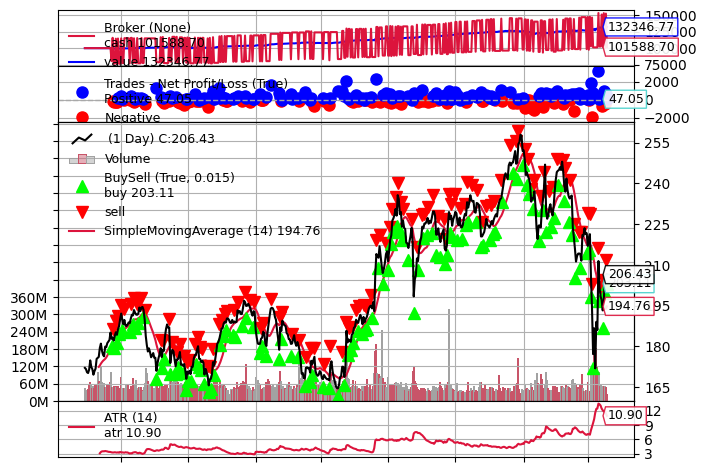

Sharpe Ratio:2.174807577695094


In [ ]:
trade_analysis = results[0].analyzers.trade_analyzer.get_analysis()
total_closed = trade_analysis.get('total', {}).get('closed', 0)
total_won = trade_analysis.get('won', {}).get('total', 0)

win_rate = (total_won / total_closed) * 100 if total_closed > 0 else 0
print(f'Win Rate: {win_rate:.2f}%')
cerebro.plot(iplot=False)

sharpe = strategy.analyzers.sharpe.get_analysis()
sharpe = 0.137*np.sqrt(252)
print(f"Sharpe Ratio:{sharpe}")

In [ ]:
predicted_returns = []
actual_returns = []

for i in range(len(X_test_lstm)):


    scaled_window = X_test_lstm[i]

    scaled_today_close = scaled_window[-1, 0]
    real_today_close = scaler.inverse_transform([[scaled_today_close]])[0][0]

    scaled_next_close_true = y_test[i]
    real_next_close_true = scaler.inverse_transform(
        np.array(scaled_next_close_true).reshape(-1,1)
    )[0][0]

    predicted_next_close = ensemble_pred.predict(scaled_window.ravel())

    actual_return = (real_next_close_true - real_today_close) / real_today_close
    predicted_return = (predicted_next_close - real_today_close) / real_today_close

    actual_returns.append(actual_return)
    predicted_returns.append(predicted_return)

df_compare = pd.DataFrame({
    'Predicted_Return': predicted_returns,
    'Actual_Return': actual_returns
})

print(df_compare)

df_compare = pd.DataFrame({
    'Predicted_Return': predicted_returns,
    'Actual_Return': actual_returns
})


print(df_compare.head())


plt.figure()
plt.plot(df_compare['Predicted_Return'], label='Predicted Return')
plt.plot(df_compare['Actual_Return'], label='Actual Return')
plt.legend()
plt.title("Predicted vs Actual Next-Day Returns")
plt.xlabel("Test Sample Index")
plt.ylabel("Return")
plt.show()